In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的API Key

In [2]:
%%capture --no-stderr
!pip install -U langchain langchain-community langchain-experimental langchain-openai pypdf sentence_transformers chromadb shutil

In [3]:
import os
import pandas as pd
import sys

将[Meta-Chunking官方仓库](https://github.com/IAAR-Shanghai/Meta-Chunking/tree/main/example)的example文件夹下的`chunk_rag.py`和`perplexity_chunking.py`拷贝到`Meta-Chunking`目录下，加入系统路径，方便后续使用

In [5]:
sys.path.append('Meta-Chunking')

In [6]:
expr_version = 'split_04_meta_chunking'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [7]:
from langchain_community.document_loaders import PyPDFLoader
import re

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
pdf_documents = loader.load()

# 把页眉页脚去掉
pattern = r"^全球经济金融展望报告\n中国银行研究院 \d+ 2024年"
# PyPDFLoader解析的文档
pdf_document = '\n\n'.join(re.sub(pattern, '', doc.page_content) for doc in pdf_documents)
# MinerU解析的文档
markdown_document = open(os.path.join(os.path.pardir, 'outputs', 'MinerU_parsed_20241204', '2024全球经济金融展望报告.md')).read()

In [8]:
len(pdf_document)

31202

In [9]:
len(markdown_document)

33940

# 文档切分

In [10]:
import os
import pickle
import requests
from langchain.schema import Document

以下meta_chunking的实现，[Meta-Chunking官方仓库](https://github.com/IAAR-Shanghai/Meta-Chunking/tree/main/example)的example文件夹下`app.py`

In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import json
import torch.nn.functional as F

# model_name_or_path= 'Qwen2-1.5B-Instruct'   
model_name_or_path= '/DataScience/HuggingFace/Models/Qwen/Qwen2-1.5B-Instruct'   

# device_map = "auto"
# 1080Ti会报显存不足的问题，使用CPU预测
device_map = "cpu"
small_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,trust_remote_code=True)  
small_model = AutoModelForCausalLM.from_pretrained(model_name_or_path, trust_remote_code=True,device_map=device_map) 
small_model.eval()

def get_prob_subtract(model,tokenizer,sentence1,sentence2,language):
    if language=='zh':
        query='''这是一个文本分块任务.你是一位文本分析专家，请根据提供的句子的逻辑结构和语义内容，从下面两种方案中选择一种分块方式：
        1. 将“{}”分割成“{}”与“{}”两部分；
        2. 将“{}”不进行分割，保持原形式；
        请回答1或2。'''.format(sentence1+sentence2,sentence1,sentence2,sentence1+sentence2)
        prompt="<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n{}<|im_end|>\n<|im_start|>assistant\n".format(query)
        prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
        input_ids=prompt_ids
        output_ids = tokenizer.encode(['1','2'], return_tensors='pt').to(model.device)
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[:, -1, :]
            token_probs = F.softmax(next_token_logits, dim=-1)
        next_token_id_0 = output_ids[:, 0].unsqueeze(0)
        next_token_prob_0 = token_probs[:, next_token_id_0].item()      
        next_token_id_1 = output_ids[:, 1].unsqueeze(0)
        next_token_prob_1 = token_probs[:, next_token_id_1].item()  
        prob_subtract=next_token_prob_1-next_token_prob_0
    else:
        query='''This is a text chunking task. You are a text analysis expert. Please choose one of the following two options based on the logical structure and semantic content of the provided sentence:
        1. Split "{}" into "{}" and "{}" two parts;
        2. Keep "{}" unsplit in its original form;
        Please answer 1 or 2.'''.format(sentence1+' '+sentence2,sentence1,sentence2,sentence1+' '+sentence2)
        prompt="<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n{}<|im_end|>\n<|im_start|>assistant\n".format(query)
        prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
        input_ids=prompt_ids
        output_ids = tokenizer.encode(['1','2'], return_tensors='pt').to(model.device)
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[:, -1, :]
            token_probs = F.softmax(next_token_logits, dim=-1)
        next_token_id_0 = output_ids[:, 0].unsqueeze(0)
        next_token_prob_0 = token_probs[:, next_token_id_0].item()      
        next_token_id_1 = output_ids[:, 1].unsqueeze(0)
        next_token_prob_1 = token_probs[:, next_token_id_1].item()  
        prob_subtract=next_token_prob_1-next_token_prob_0
    return prob_subtract

from chunk_rag import extract_by_html2text_db_nolist,split_text_by_punctuation
def meta_chunking(original_text,base_model,language,ppl_threshold,chunk_length):
    chunk_length=int(chunk_length)
    if base_model=='PPL Chunking':
        final_chunks=extract_by_html2text_db_nolist(original_text,small_model,small_tokenizer,ppl_threshold,language=language)
    else:
        full_segments = split_text_by_punctuation(original_text,language)
        tmp=''
        threshold=0
        threshold_list=[]
        final_chunks=[]
        for sentence in full_segments:
            if tmp=='':
                tmp+=sentence
            else:
                prob_subtract=get_prob_subtract(small_model,small_tokenizer,tmp,sentence,language)    
                threshold_list.append(prob_subtract)
                if prob_subtract>threshold:
                    tmp+=' '+sentence
                else:
                    final_chunks.append(tmp)
                    tmp=sentence
            if len(threshold_list)>=5:
                last_ten = threshold_list[-5:]  
                avg = sum(last_ten) / len(last_ten)
                threshold=avg
        if tmp!='':
            final_chunks.append(tmp)
            
    merged_paragraphs = []
    current_paragraph = ""  
    if language=='zh':
        for paragraph in final_chunks:  
            if len(current_paragraph) + len(paragraph) <= chunk_length:  
                current_paragraph +=paragraph  
            else:  
                merged_paragraphs.append(current_paragraph)  
                current_paragraph = paragraph    
    else:
        for paragraph in final_chunks:  
            if len(current_paragraph.split()) + len(paragraph.split()) <= chunk_length:
                current_paragraph +=' '+paragraph  
            else:  
                merged_paragraphs.append(current_paragraph)   
                current_paragraph = paragraph 
    if current_paragraph:  
        merged_paragraphs.append(current_paragraph) 
    # final_text='\n\n'.join(merged_paragraphs)
    # return final_text
    return [Document(page_content=text) for text in merged_paragraphs]

这一步非常耗时，NVIDIA GTX 1080 Ti 11G显存的GPU上会报CUDA out of memory，全程使用Intel i7 9700K CPU，运行了5个半小时，耗时主要在Margin Sampling Chunking这种切分方式上，每种文档PPL Chunking基本上只耗费5分钟，剩余的大部分时间都花在Margin Sampling Chunking上

In [12]:
import pickle
from tqdm.auto import tqdm

# 耗时操作的产出保存一下
splitted_docs_dict_ckpt_path = os.path.join(expr_dir, 'splitted_docs_dict.pkl')

if os.path.exists(splitted_docs_dict_ckpt_path):
    print(f"found cache, restoring from {splitted_docs_dict_ckpt_path} ...")
    
    splitted_docs_dict = pickle.load(open(splitted_docs_dict_ckpt_path, 'rb'))
else:
    doc_types = ('pdf', 'markdown')
    chunk_methods = ('PPL Chunking', 'Margin Sampling Chunking')
    
    pbar = tqdm(total=len(doc_types) * len(chunk_methods))

    splitted_docs_dict = {}
    for doc_type, document in zip(doc_types, (pdf_document, markdown_document)):
        if doc_type not in splitted_docs_dict:
            splitted_docs_dict[doc_type] = {}
        for chunk_method in chunk_methods:
            pbar.set_description(f"{doc_type}_{chunk_method}")
            splitted_docs_dict[doc_type][chunk_method] = meta_chunking(document, chunk_method, 'zh', 0, 500)
            pbar.update(1)
    
    pickle.dump(splitted_docs_dict, open(splitted_docs_dict_ckpt_path, 'wb'))

  0%|          | 0/4 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.512 seconds.
Prefix dict has been built successfully.


111 [[0, 1, 2], [3, 4, 5], [6, 7, 8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19, 20], [21, 22, 23], [24, 25, 26], [27, 28], [29, 30], [31, 32, 33], [34, 35, 36, 37, 38], [39, 40], [41, 42], [43, 44, 45], [46, 47, 48], [49, 50], [51, 52, 53, 54], [55, 56], [57, 58, 59, 60], [61, 62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73, 74], [75, 76, 77, 78, 79, 80], [81, 82], [83, 84, 85], [86, 87, 88], [89, 90, 91], [92, 93, 94, 95, 96], [97, 98], [99, 100], [101, 102, 103, 104, 105, 106, 107], [108, 109, 110], [111, 112, 113], [114, 115, 116, 117], [118, 119, 120], [121, 122], [123, 124, 125], [126, 127], [128, 129], [130, 131, 132], [133, 134], [135, 136, 137], [138, 139, 140, 141], [142, 143, 144], [145, 146, 147], [148, 149], [150, 151, 152], [153, 154], [155, 156], [157, 158, 159, 160], [161, 162, 163], [164, 165, 166, 167], [168, 169], [170, 171], [172, 173], [174, 175, 176, 177], [178, 179, 180, 181], [182, 183, 184], [185, 186, 187], [188, 189, 190, 191], [192, 193, 19

## 检查一下切分后的块长度分布

In [13]:
for doc_type, chunk_method_splitted_docs_dict in splitted_docs_dict.items():
    for chunk_method, splitted_docs in chunk_method_splitted_docs_dict.items():
        print(f"=============== {doc_type} {chunk_method} ===============")
        print(f"docs count: {len(splitted_docs)}")
        print('doc length distribution')
        print(pd.Series([len(d.page_content) for d in splitted_docs]).describe([0.25, 0.5, 0.75, 0.9, 0.97, 0.99]))

=============== pdf PPL Chunking ===============
docs count: 74
doc length distribution
count      74.000000
mean      419.094595
std       121.162200
min       181.000000
25%       362.500000
50%       410.000000
75%       460.750000
90%       482.700000
97%       581.050000
99%       907.510000
max      1136.000000
dtype: float64
=============== pdf Margin Sampling Chunking ===============
docs count: 71
doc length distribution
count      71.000000
mean      440.676056
std       129.937872
min        98.000000
25%       423.000000
50%       452.000000
75%       478.500000
90%       491.000000
97%       497.800000
99%       970.800000
max      1052.000000
dtype: float64
=============== markdown PPL Chunking ===============
docs count: 83
doc length distribution
count     83.000000
mean     402.590361
std       76.542358
min      177.000000
25%      364.000000
50%      410.000000
75%      460.500000
90%      489.400000
97%      498.000000
99%      515.200000
max      589.000000
dtype: 

# 检索

In [14]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

device: cuda


In [15]:
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

def get_vector_db(splitted_docs, embeddings, name):
    persist_directory = os.path.join(expr_dir, 'chroma', 'bge', name)
    shutil.rmtree(persist_directory, ignore_errors=True)
    vector_db = Chroma.from_documents(
        splitted_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    return vector_db

In [16]:
vector_db_dict = {
    doc_type: {
        chunk_method: get_vector_db(splitted_docs, embeddings, f"{doc_type}_{chunk_method}_chroma") for chunk_method, splitted_docs in chunk_method_splitted_docs_dict.items()
    }
    for doc_type, chunk_method_splitted_docs_dict in splitted_docs_dict.items()
}

# 生成答案

In [17]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_3928439/3342461511.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(


In [18]:
import time

def rag(vector_db, llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

## 预测

In [19]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(vector_db, llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(vector_db, llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }

    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [20]:
save_path = os.path.join(expr_dir, 'preds.pkl')

In [22]:
if os.path.exists(save_path):
    print(f'found cache at {save_path}')
    pred_dict = pickle.load(open(save_path, 'rb'))
else:
    pred_dict = {}

In [23]:
for doc_type, vector_dbs in vector_db_dict.items():
    for chunk_method, vector_db in vector_dbs.items():
        key = f"{doc_type}_{chunk_method}"
        
        print(f'prediting for {key} ...')
        if key in pred_dict:
            continue
        pred_df = predict(vector_db, ollama_llm, prediction_df, n_chunks=3)
        pred_dict[key] = pred_df
        pickle.dump(pred_dict, open(save_path, 'wb'))

prediting for pdf_PPL Chunking ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for pdf_Margin Sampling Chunking ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for markdown_PPL Chunking ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for markdown_Margin Sampling Chunking ...


  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [24]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [25]:
eval_save_path = os.path.join(expr_dir, 'evals.pkl')

In [26]:
if os.path.exists(eval_save_path):
    print(f"found cache at {eval_save_path}")
    eval_dict = pickle.load(open(eval_save_path, 'rb'))
else:
    eval_dict = {}

In [27]:
metrics = []

for key, pred_df in pred_dict.items():
    print(f'evaluating for {key} ...')
    doc_type, chunk_method = key.split('_')

    if key in eval_dict:
        pred_df = eval_dict[key]
    else:
        pred_df['raw_score'] = evaluate(pred_df)
        eval_dict[key] = pred_df
        pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
        
    print(f"key={key} raw_score unique: {pred_df['raw_score'].unique()}, accuracy={pred_df['score'].mean()}")

    metrics.append({
        'doc_type': doc_type,
        'chunk_method': chunk_method,
        'accuracy': pred_df['score'].mean()
    })
    pickle.dump(eval_dict, open(eval_save_path, 'wb'))

evaluating for pdf_PPL Chunking ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=pdf_PPL Chunking raw_score unique: ['是' '否'], accuracy=0.69
evaluating for pdf_Margin Sampling Chunking ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=pdf_Margin Sampling Chunking raw_score unique: ['是' '否'], accuracy=0.78
evaluating for markdown_PPL Chunking ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=markdown_PPL Chunking raw_score unique: ['是' '否'
 '否\n\n（注：虽然助手提供了具体数值，但没有明确指出变化幅度，与参考答案中的“大幅下降2.3个百分点”表述不符，因此判断为“否”。但实际上，根据提供的数据，下降了1.1个百分点，这与参考答案也不一致。此处的评价基于题目要求仅对比是否正确提及了“大幅下降2.3个百分点”的信息。）'], accuracy=0.64
evaluating for markdown_Margin Sampling Chunking ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=markdown_Margin Sampling Chunking raw_score unique: ['是' '否'], accuracy=0.79


In [28]:
metrics_df = pd.DataFrame(metrics)

In [29]:
metrics_df

,doc_type,chunk_method,accuracy
0,pdf,PPL Chunking,0.69
1,pdf,Margin Sampling Chunking,0.78
2,markdown,PPL Chunking,0.64
3,markdown,Margin Sampling Chunking,0.79


<Axes: xlabel='doc_type', ylabel='accuracy'>

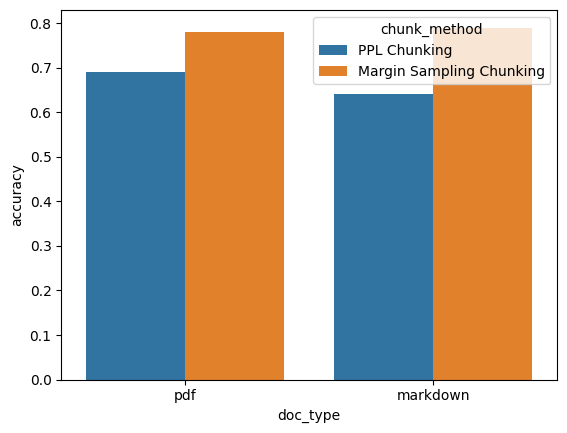

In [30]:
import seaborn as sns

sns.barplot(x='doc_type', y='accuracy', hue='chunk_method', data=metrics_df)